# Convolutional Autoencoder, Cifar10

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision.utils import save_image

## Set Configs

In [3]:
# number of epochs
num_epochs = 5

# images per batch
batch_size = 128

# number of GPUs availabele
n_gpu = 1

# 10 classes included in cifar10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# weight decay for optimizer of autoencoder model
weight_decay = 1e-5

## Configure Data Loader

In [4]:
transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform), 
                                           batch_size=32, shuffle=False, num_workers=4)

Files already downloaded and verified


In [6]:
test_loader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform), 
                                           batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


In [7]:
# decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and n_gpu > 0) else 'cpu')

## Build Convolutional Autoencoder Architecture

<img src='images/autoencoder-architecture.png' width='75%'/>

In [8]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 6, kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6, 3, kernel_size=5),
            nn.ReLU(True),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

#### Initialize Autoencoder

In [9]:
autoencoder = Autoencoder().to(device)

## Define Loss Function

In [10]:
reconstruction_loss = nn.MSELoss()
if (device.type == 'cuda'): reconstruction_loss.cuda()

## Set Optimizer

In [11]:
optimizer = torch.optim.Adam(autoencoder.parameters(), weight_decay=weight_decay)

## Train The Network

In [12]:
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Sigmoid()
  )
)

In [13]:
r_loss_to_display = []
prev_time = time.time()
for epoch in range(num_epochs):
    
    r_loss = []
    for i, (images, _) in enumerate(train_loader):
        images = Variable(images).cuda()
        optimizer.zero_grad()
        
        reconstruction = autoencoder(images)
        loss = reconstruction_loss(reconstruction, images)
        r_loss.append(loss)
        
        loss.backward()
        optimizer.step()
        
        # determine approximate time left
        batches_done = epoch * len(train_loader) + i
        batches_left = num_epochs * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
        
    r_loss_to_display.append(sum(r_loss)/len(r_loss))
    print('epoch [{}/{}], reconstruction loss: {:.4f}, ETA: {}'.format(epoch+1, num_epochs, loss.data.cpu().numpy(), time_left, ))

epoch [1/5], reconstruction loss: 0.3859, ETA: 0:00:14.827809
epoch [2/5], reconstruction loss: 0.3851, ETA: 0:00:11.322722
epoch [3/5], reconstruction loss: 0.3847, ETA: 0:00:07.577617
epoch [4/5], reconstruction loss: 0.3845, ETA: 0:00:03.690832
epoch [5/5], reconstruction loss: 0.3843, ETA: 0:00:00.002468


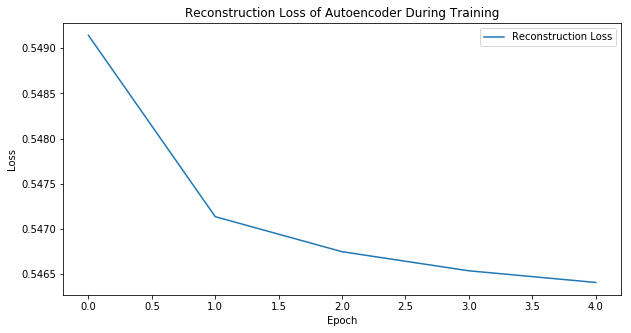

In [14]:
plt.figure(figsize=(10,5))
plt.title("Reconstruction Loss of Autoencoder During Training")
plt.plot(r_loss_to_display, label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/autoencoder'): os.makedirs('./images/autoencoder')
plt.savefig('./images/autoencoder/final_loss.png')
plt.show()

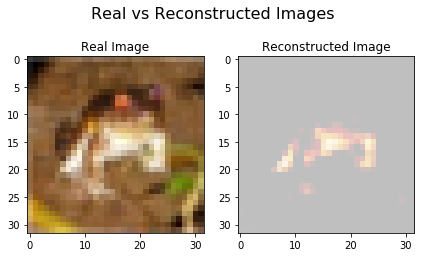

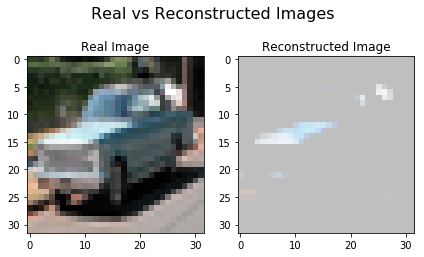

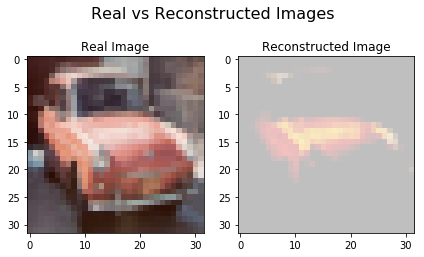

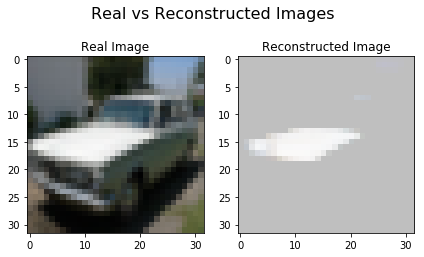

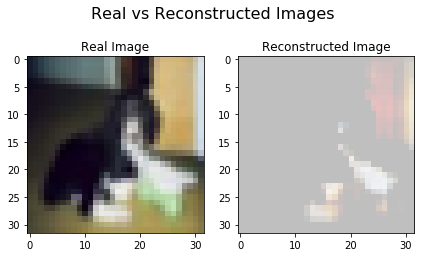

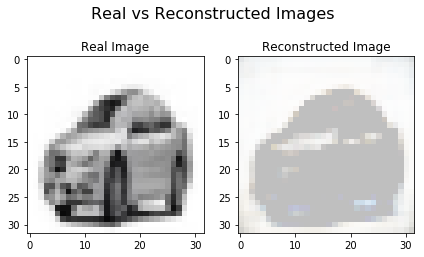

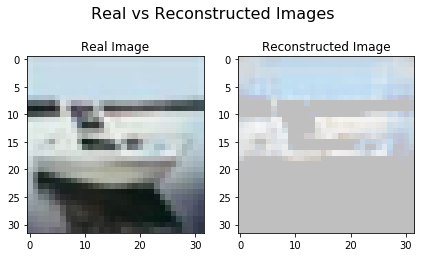

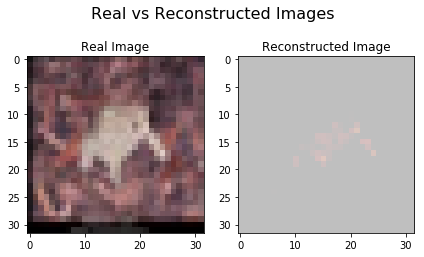

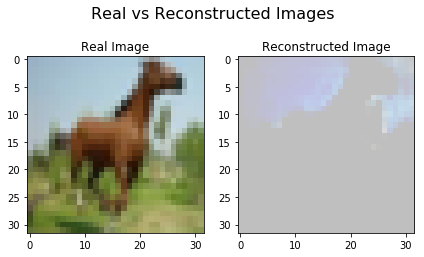

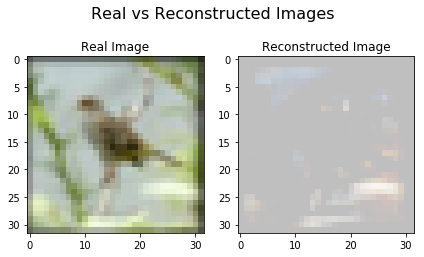

In [26]:
for i, (images, _) in enumerate(train_loader):
    autoencoder.eval()
    images = images.type(torch.cuda.FloatTensor)
    reconstruction = autoencoder.encoder(images)
    results = autoencoder.decoder(reconstruction)
    
    fig, axarr = plt.subplots(1,2)
    fig.suptitle("Real vs Reconstructed Images", fontsize=16)
    
    images_to_show = ((images * 0.5) + 0.5)
    axarr[0].set_title('Real Image')
    axarr[0].imshow(images_to_show.cpu().detach().numpy()[0].transpose(1, 2, 0))
    
    results_to_show = ((results * 0.5) + 0.5)
    axarr[1].set_title('Reconstructed Image')
    axarr[1].imshow(results_to_show.cpu().detach().numpy()[0].transpose(1, 2, 0))
    
    fig.tight_layout()
    plt.savefig('./images/autoencoder/real_vs_recons{}.png'.format(i+1))
    if i+1 == 10: break
        
plt.show()

---